In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.models as models


import yelp_dataloader
import numpy as np
import matplotlib.pyplot as plt
import os

from timeit import default_timer as timer

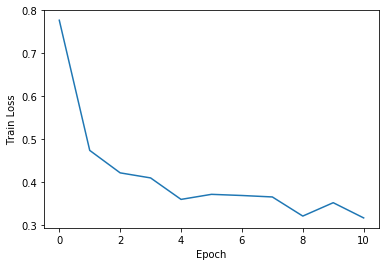

In [12]:
x = list(range(11))
loss = [0.7767, 0.4731, 0.4207, 0.4089, 0.3588, 0.3706, 0.3679, 0.3645, 0.3199, 0.3511, 0.3156]
train_acc = [49.42, 77.37, 80.93, 82.06, 82.22, 82.77, 83.15, 83.73, 83.83, 83.96, 84.10]
dev_acc = [49.09, 77.41, 80.74, 82.04, 82.14, 82.80, 83.31, 83.78, 83.99, 84.04, 84.02]

plt.plot(x, loss)
#plt.plot(x, train_acc)
#plt.plot(x, dev_acc)
#plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
#plt.legend()
file_name = os.path.join('/home/Afshin/cs231n/cs231n-project', 'bce_loss.png')
plt.savefig(file_name)

In [2]:
print_every = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype =torch.FloatTensor if device == 'cpe' else torch.cuda.FloatTensor
print(device)
print(dtype)

cuda:0
<class 'torch.cuda.FloatTensor'>


In [3]:
dir_path = '/home/Afshin/cs231n/cs231n-project/yelp-data'
num_biz = 2000
max_image = None
image_size= 224
yelp_ds = yelp_dataloader.YelpDataset(dir_path, num_biz=num_biz, seed=101, offset=0,\
                                         max_image=max_image, image_size=image_size)
print('size of train dataset = %d' % len(yelp_ds))
print('Number of train businesses = %d' % len(yelp_ds.sample_biz_ids))
print()

/home/Afshin/cs231n/cs231n-project/yelp-data/train.csv parsed in 0.660614 seconds
Number of biz = 2000
Parsing train_photo_to_biz_ids.csv
train_photo_to_biz_ids.csv parsed in 14.726376 seconds
10000 image paths loaded.
20000 image paths loaded.
30000 image paths loaded.
40000 image paths loaded.
50000 image paths loaded.
60000 image paths loaded.
70000 image paths loaded.
80000 image paths loaded.
90000 image paths loaded.
100000 image paths loaded.
110000 image paths loaded.
Images paths of 1000 businesses loaded.
120000 image paths loaded.
130000 image paths loaded.
140000 image paths loaded.
150000 image paths loaded.
160000 image paths loaded.
170000 image paths loaded.
180000 image paths loaded.
190000 image paths loaded.
200000 image paths loaded.
210000 image paths loaded.
220000 image paths loaded.
230000 image paths loaded.
Images paths of 2000 businesses loaded.
Image paths load time =  0.91626790600003
size of train dataset = 234842
Number of train businesses = 2000



In [4]:
batch_size=64
NUM_PHOTOS = len(yelp_ds.sample_biz_ids)
indices = np.random.choice(NUM_PHOTOS, 100000)
loader_train = DataLoader(yelp_ds, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(indices[:90000]), num_workers=4)

loader_dev = DataLoader(yelp_ds, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(indices[90000:]), num_workers=4)

In [5]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y, photo_id, biz_id in loader: # x = imgs, y = label_tensor
            x = x.type(dtype)
            y = y.type(dtype)
            scores = model(x).type(dtype)
            preds = torch.zeros(scores.size()).type(dtype)
            preds[scores > 0.47] = 1.
            batch_corrects = (preds == y).sum()
            num_correct += batch_corrects
            num_samples += preds.size()[0] * preds.size()[1]
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [8]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    print('dtype, ', dtype)
    print('device, ', device)
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print('Epoch %d' % e)
        for t, (x, y, photo_id, biz_id) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.type(dtype)
            y = y.type(dtype)

            scores = model(x)
            loss = F.binary_cross_entropy_with_logits(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print('Train')
                check_accuracy(loader_train, model)
                print('dev')
                check_accuracy(loader_dev, model)
                print()

In [9]:
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 9)

resnet = resnet.to(device)
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)

start = timer()
NUM_EPOCHS = 10
train_model(resnet, optimizer, epochs=NUM_EPOCHS)
end = timer()
print('Training time for %d epochs = %f seconds.' % (NUM_EPOCHS, (end - start)))

dtype,  <class 'torch.cuda.FloatTensor'>
device,  cuda:0
Epoch 0
Iteration 0, loss = 0.7767
Train
Got 400304 / 810000 correct (49.42)
dev
Got 44179 / 90000 correct (49.09)

Iteration 500, loss = 0.4972
Train
Got 602591 / 810000 correct (74.39)
dev
Got 66877 / 90000 correct (74.31)

Iteration 1000, loss = 0.4731
Train
Got 626737 / 810000 correct (77.37)
dev
Got 69669 / 90000 correct (77.41)

Epoch 1
Iteration 0, loss = 0.4443
Train
Got 640480 / 810000 correct (79.07)
dev
Got 71055 / 90000 correct (78.95)

Iteration 500, loss = 0.4733
Train
Got 648072 / 810000 correct (80.01)
dev
Got 71878 / 90000 correct (79.86)

Iteration 1000, loss = 0.4207
Train
Got 655497 / 810000 correct (80.93)
dev
Got 72670 / 90000 correct (80.74)

Epoch 2
Iteration 0, loss = 0.4204
Train
Got 655237 / 810000 correct (80.89)
dev
Got 72787 / 90000 correct (80.87)

Iteration 500, loss = 0.4257
Train
Got 659311 / 810000 correct (81.40)
dev
Got 73256 / 90000 correct (81.40)

Iteration 1000, loss = 0.4089
Train
Got 664

In [10]:
print(type(resnet))
resnet_yelp_file = '/home/Afshin/cs231n/cs231n-project/yelp-resnet-2.pt'
torch.save(resnet.state_dict(), resnet_yelp_file)

# Build model and load state_dict
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 9)
resnet.load_state_dict(torch.load(resnet_yelp_file))
resnet = resnet.to(device)

<class 'torchvision.models.resnet.ResNet'>
